In [2]:
import hail as hl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from bokeh.plotting import show
from bokeh.io import output_notebook
output_notebook()
import scipy.stats as stats
import pandas as pd

Loading BokehJS ...

In [3]:
mt = hl.read_matrix_table('gs://nbaya/split/meta_split/ukb31063.hm3_50_gmt300_batch_1.mt')

Initializing Spark and Hail with default parameters...
Running on Apache Spark version 2.2.1
SparkUI available at http://10.128.0.6:4040
Welcome to
     __  __     <>__
    / /_/ /__  __/ /
   / __  / _ `/ / /
  /_/ /_/\_,_/_/_/   version 0.2-e60bdb1a125a
LOGGING: writing to /home/hail/hail-20181211-1349-0.2-e60bdb1a125a.log


In [4]:
print(mt.count())
mt.describe()

(1089172, 300)
----------------------------------------
Global fields:
    None
----------------------------------------
Column fields:
    'group_id': int32 
----------------------------------------
Row fields:
    'locus': locus<GRCh37> 
    'alleles': array<str> 
    'rsid': str 
    'varid': str 
----------------------------------------
Entry fields:
    'beta': float64 
    'standard_error': float64 
    'beta_int': float64 
    'standard_error_int': float64 
----------------------------------------
Column key: ['group_id']
Row key: ['locus', 'alleles']
----------------------------------------


In [18]:
mt.aggregate_entries(hl.agg.stats(mt.beta))

Struct(mean=1.2777184112378727e-05, stdev=0.0461605977876273, min=-0.9545572966055128, max=0.8065243677215003, n=326751600, sum=4174.965352214329)

In [ ]:
mt.aggregate_entries(hl.agg.stats(mt.standard_error))

In [ ]:
# ht.export('gs://nbaya/split/ukb31063.hm3_50_gmt300_batch_1_betas.tsv')

In [ ]:
ht.describe()

In [ ]:
sns.kdeplot(mt.beta.take(326751600))

In [ ]:
mt.aggregate_entries(hl.agg.corr(mt.beta, mt.beta_int))

In [ ]:
mt.aggregate_entries(hl.agg.corr(mt.standard_error, mt.standard_error_int))

In [ ]:
for i in range(1,7):
    plt.subplot(3,2,i)
    
plt.tight_layout()

In [6]:
show(hl.plot.histogram(mt.filter_cols(mt.group_id==0).beta))
show(hl.plot.histogram(mt.filter_cols(mt.group_id==1).beta))

In [45]:
beta_means = mt.aggregate_entries(hl.agg.group_by(mt.group_id, hl.agg.mean(mt.beta)))
se_means = mt.aggregate_entries(hl.agg.group_by(mt.group_id, hl.agg.mean(mt.standard_error)))

In [47]:
beta_rsid_means = mt.aggregate_entries(hl.agg.group_by(mt.rsid, hl.agg.mean(mt.beta)))
se_rsid_means = mt.aggregate_entries(hl.agg.group_by(mt.rsid, hl.agg.mean(mt.standard_error)))

In [48]:
beta_means_list = [b for a, b in beta_means.items()]
se_means_list = [b for a, b in se_means.items()]

In [49]:
beta_rsid_means_list = [b for a, b in beta_rsid_means.items()]
se_rsid_means_list = [b for a, b in se_rsid_means.items()]

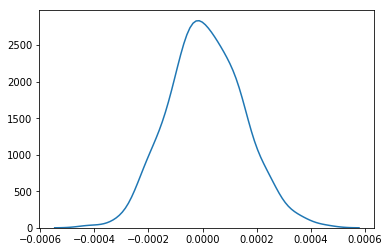

In [55]:
sns.kdeplot(beta_means_list)


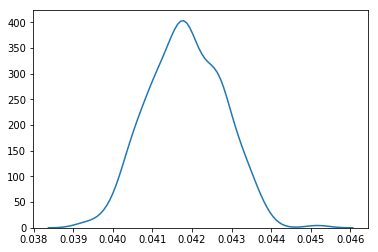

In [51]:
sns.kdeplot(se_means_list)

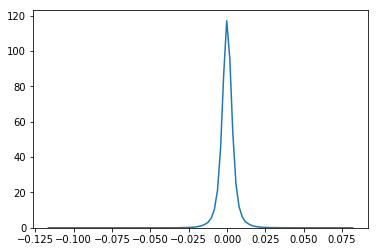

In [53]:
sns.kdeplot(beta_rsid_means_list)


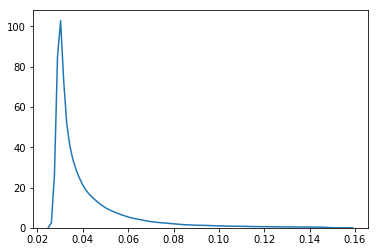

In [54]:
sns.kdeplot(se_rsid_means_list)

In [58]:
gmt = mt.add_col_index()
n_chunks = 300
batch='1'
i=1
pi = ['A']*int(n_chunks/2) + ['B']*int(n_chunks/2)
seed_id = int(batch+str(i).zfill(4)) #OPTION 2: create a seed_id unique to every split
randstate = np.random.RandomState(seed_id) #OPTION 2: seed with seed_id

randstate.shuffle(pi)
gmt_shuf = gmt.annotate_cols(label = hl.literal(pi)[hl.int32(gmt.col_idx)])

mt = gmt_shuf.group_cols_by(gmt_shuf.label).aggregate(unnorm_meta_beta=hl.agg.sum(gmt_shuf.beta / gmt_shuf.standard_error ** 2),
                            inv_se2 = hl.agg.sum(1 / gmt_shuf.standard_error ** 2)) 

In [94]:
mt = mt.annotate_entries(meta_beta = mt.unnorm_meta_beta/mt.inv_se2)
mt = mt.annotate_entries(meta_se = hl.sqrt(1/mt.inv_se2))

In [95]:
meta_beta_A = np.asarray(mt.aggregate_entries(hl.agg.filter(mt.label=='A', hl.agg.collect(mt.meta_beta))))
meta_beta_B = np.asarray(mt.aggregate_entries(hl.agg.filter(mt.label=='B', hl.agg.collect(mt.meta_beta))))
meta_se_A = np.asarray(mt.aggregate_entries(hl.agg.filter(mt.label=='A', hl.agg.collect(mt.meta_se))))
meta_se_B = np.asarray(mt.aggregate_entries(hl.agg.filter(mt.label=='B', hl.agg.collect(mt.meta_se))))

In [96]:
stats.ttest_ind(meta_beta_A,meta_beta_B)

Ttest_indResult(statistic=1.0879185433395682, pvalue=0.27663118951435095)

In [97]:
stats.ttest_ind(meta_se_A,meta_se_B)

Ttest_indResult(statistic=0.8264986014104208, pvalue=0.40852140163203166)

In [98]:
stats.pearsonr(meta_beta_A, meta_beta_B)

(0.021938436346914583, 4.8167825015472627e-116)

In [99]:
stats.pearsonr(meta_se_A, meta_se_B)

(0.026459069187572723, 6.69279393586117e-168)

In [100]:
stats.pearsonr(meta_beta_A, meta_se_A)

(-0.002001561653327086, 0.03671694549899499)

In [101]:
stats.pearsonr(meta_beta_B, meta_se_B)

(-0.00043915728859709167, 0.6467232834788039)

In [102]:
meta_beta_diff = meta_beta_A-meta_beta_B
meta_se_diff = meta_se_A-meta_se_B

In [115]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(24, 16), dpi=800, facecolor='w', edgecolor='k')

plt.plot(range(len(meta_beta_diff)),meta_beta_diff,'.-',color=[0, 0, 1])
plt.fill_between(range(len(meta_beta_diff)),meta_beta_diff-2*meta_se_diff,meta_beta_diff+2*meta_se_diff,
                 color=[0, 0.5, 1])
plt.xlabel('rsid index')
plt.ylabel('difference between meta betas (A - B)')
plt.legend(['meta_beta_diff','95% CI from se'])
plt.title('Difference in meta betas across variants')
# fig = plt.gcf()
# fig.set_size_inches(6*1.2, 4*1.2)
# fig.savefig('gs://nbaya/split/meta_beta_diff.png',dpi=1000)

Text(0.5,1,'Difference in meta betas across variants')

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7f1253b498c8> (for post_execute):


OverflowError: In draw_markers: Exceeded cell block limit

OverflowError: Exceeded cell block limit (set 'agg.path.chunksize' rcparam)

<Figure size 19200x12800 with 1 Axes>

(-0.02, 0.02)

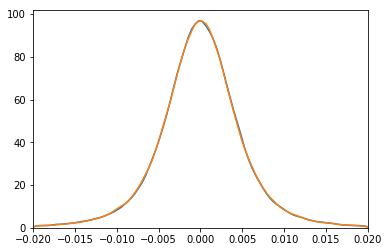

In [93]:
sns.kdeplot(meta_beta_A[(meta_beta_A < 0.02) & (meta_beta_A > -0.02)])
sns.kdeplot(meta_beta_B[(meta_beta_B < 0.02) & (meta_beta_B > -0.02)])
plt.xlim([-0.02, 0.02])

In [117]:
meta_beta_df = pd.DataFrame({'meta_beta_A':meta_beta_A,'meta_beta_B':meta_beta_B,'meta_se_A':meta_se_A, 'meta_se_B':meta_se_B})

In [120]:
meta_beta_df.to_csv('gs://nbaya/meta_beta_df.tsv.gz',sep='\t',compression='gzip')

FileNotFoundError: [Errno 2] No such file or directory: 'gs://nbaya/meta_beta_df.tsv.gz'

In [122]:
import os
cwd = os.getcwd()
print(cwd)

/home/hail
